МЕТОД РУЧНОГО ПОИСКА И ЗДРАВОГО СМЫСЛА

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sber_data=pd.read_csv('data/sber_data.csv', sep=',')
sber_data['life_sq'].describe()

# Что нам говорит метод describe()? Во-первых, у нас есть квартиры с нулевой жилой площадью. Во-вторых, в то время 
# как 75-й квантиль равен 43, максимум превышает 7 тысяч квадратных метров (целый дворец, а не квартира!). 
# Найдём число квартир с нулевой жилой площадью:

print(sber_data[sber_data['life_sq'] == 0].shape[0]) # 45 - скорее всего это аппартаменты

# А теперь выведем здания с жилой площадью более 7 000 квадратных метров:

display(sber_data[sber_data['life_sq'] > 7000]) 
# Жилая площадь больше чем общая почти в 100 раз. Глянем, сколько таких объектов

outliers = sber_data[sber_data['life_sq'] > sber_data['full_sq']]
print(outliers.shape[0]) # 37. Это ошибочные данные, поэтому дропаем их

cleaned = sber_data.drop(outliers.index, axis=0)
print(f'Результирующее число записей: {cleaned.shape[0]}')

# Ещё пример: давайте посмотрим на признак числа этажей (floor).
display(sber_data['floor'].describe())
# Убеждаемся в том, что здания выше 70 этажей находятся на территории комплекса Москва-Сити (Пресненский район). 
# В Ломоносовском районе таких жилых высоток нет. Получается, что данное наблюдение — выброс.

45


,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
13546,13549,79,7478.0,8.0,Poselenie Voskresenskoe,NaN,0,NaN,0,0,...,5.072389,1.210613,0.826052,1.582378,0.756119,21.472421,14.917332,no data,0,7705000


37
Результирующее число записей: 30434


count    30304.000000
mean         7.670803
std          5.319989
min          0.000000
25%          3.000000
50%          6.500000
75%         11.000000
max         77.000000
Name: floor, dtype: float64

МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (МЕТОД ТЬЮКИ)

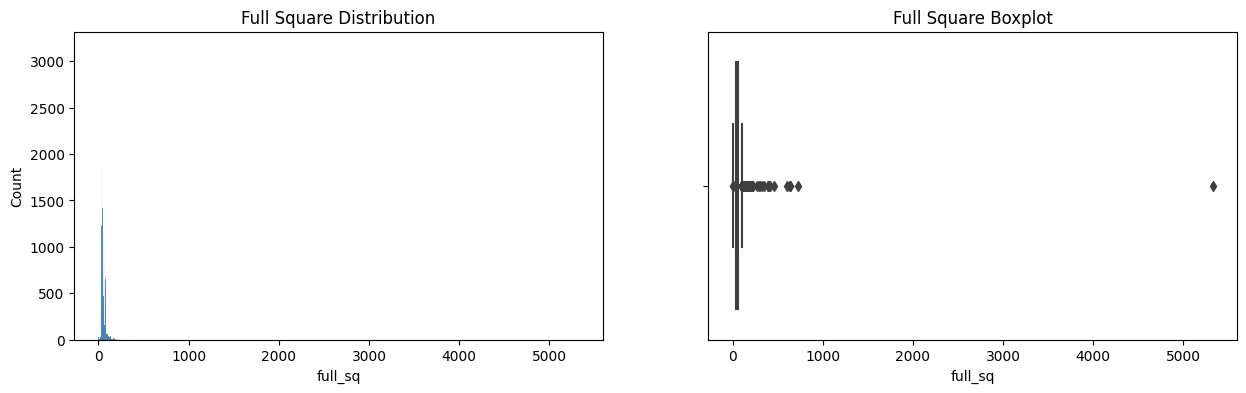

In [10]:
# Отличным помощником в поиске потенциальных выбросов является визуализация. Если признак является числовым, 
# то можно построить гистограмму или коробчатую диаграмму, чтобы найти аномалии.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=sber_data, x='full_sq', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=sber_data, x='full_sq', ax=axes[1]);
boxplot.set_title('Full Square Boxplot'); 
# Основная масса квартир имеет общую площадь менее 250 квадратных метров, и лишь несколько невзрачных наблюдений 
# выбиваются из этого интервала. Максимальная площадь, судя по гистограмме, превышает 5 000 квадратных метров.
# Одним из таких подходов является метод межквартильного размаха (его еще называют методом Тьюки), 
# который используется для построения коробчатой диаграммы.

!!!АЛГОРИТМ МЕТОДА ТЪЮКИ!!!

Число выбросов по методу Тьюки: 963
Результирующее число записей: 29508


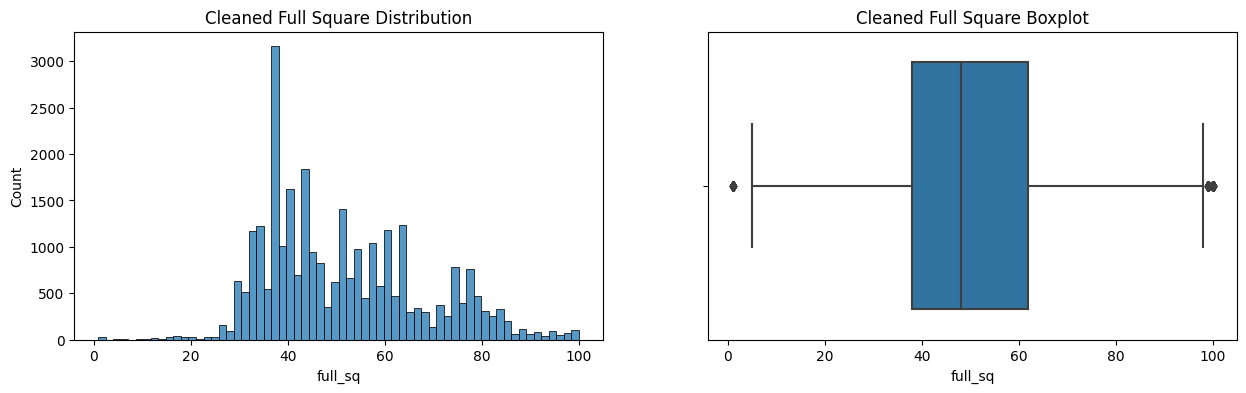

In [12]:
# Квантили вычисляются с помощью метода quantile(). Потенциальные выбросы определяются при помощи фильтрации 
# данных по условию выхода за пределы верхней или нижней границы.
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# Применим эту функцию к таблице sber_data и признаку full_sq, а также выведем размерности результатов:

outliers, cleaned = outliers_iqr(sber_data, 'full_sq')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

# Согласно классическому методу Тьюки, под выбросы у нас попали 963 записи в таблице. 
# Давайте построим гистограмму и коробчатую диаграмму на новых данных cleaned_sber_data:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot'); 

# На первый взгляд — стерильно. Однако если присмотреться, то коробчатая диаграмма всё ещё продолжает говорить, 
# что в данных есть одиночные выбросы с обеих сторон от границ. К тому же у нас 
# сильно урезался диапазон жилой площади — максимальная площадь составляет около 100 кв. м.
# Как же так, неужели метод не работает? Причина кроется в том, что после удаления выбросов квартили рассчитываются 
# заново по новым данным, и так оказалось, что из-за свойств распределения были снова найдены точки, 
# которые считаются выбросами. 
# Классический метод межквартильного размаха не учитывает особенностей распределения! Он требует, чтобы данные 
# были распределены плюс-минус нормально (гистограмма должна быть похожа на колокол) и требует от распределения 
# примерной симметричности (чтобы у гистограммы были одинаковые хвосты в обе стороны). У нас же распределение 
# (даже после отсечения выбросов) отличается от заявленных критериев. Оно несимметрично: 
# правый хвост изначального распределения гораздо длиннее левого (для Москвы вполне естественны квартиры с площадью 
# свыше 100 квадратных метров) и вовсе не колоколообразно. Попросту говоря, выбор метода поиска не оправдал себя.

Задание 6.1

In [ ]:
# Давайте немного модифицируем функцию outliers_iqr(). Добавьте в неё параметры left и right, 
# которые задают число IQR влево и вправо от границ ящика (пусть по умолчанию они равны 1.5). Функция, как и раньше, 
# должна возвращать потенциальные выбросы и очищенный DataFrame.

def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x> upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned


Задание 6.2

Число выбросов по методу Тьюки: 59
Результирующее число записей: 30403


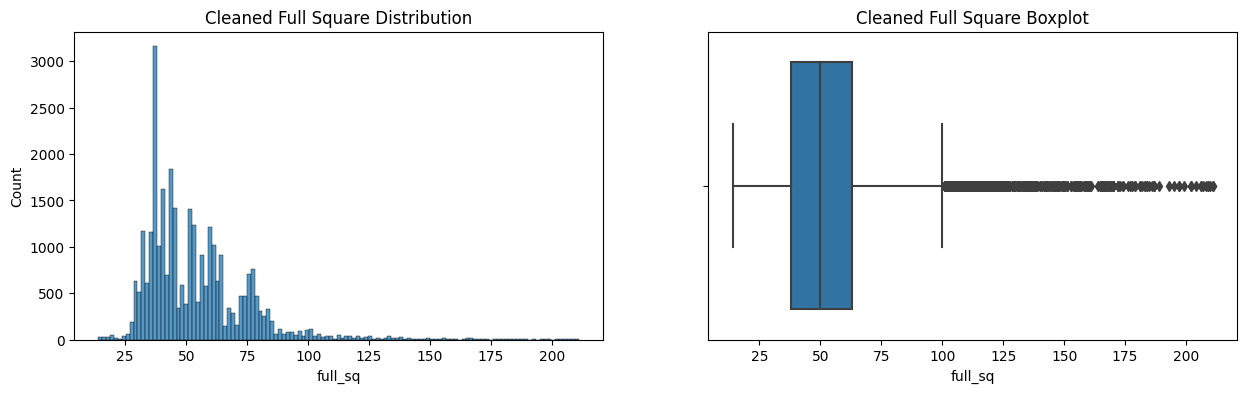

In [15]:
# Давайте ослабим границы метода Тьюки справа и усилим их влево. Примените модифицированную функцию outliers_iqr_mod() 
# к признаку full_sq из таблицы sber_data данным с параметрами left=1 и right=6. 
# Результаты работы поместите в переменные outliers и cleaned. Чему равно результирующее число выбросов в данных?
def outliers_iqr_mod(data, feature, left=1, right=6):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x> upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(sber_data, 'full_sq')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

# на основе новых данных строим диаграмму:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot'); 

МЕТОД Z-ОТКЛОНЕНИЙ (МЕТОД СИГМ)

-0.14263612203024953
Число выбросов по методу z-отклонения: 33
Результирующее число записей: 30438
['Poselenie Rogovskoe' 'Poselenie Kievskij']


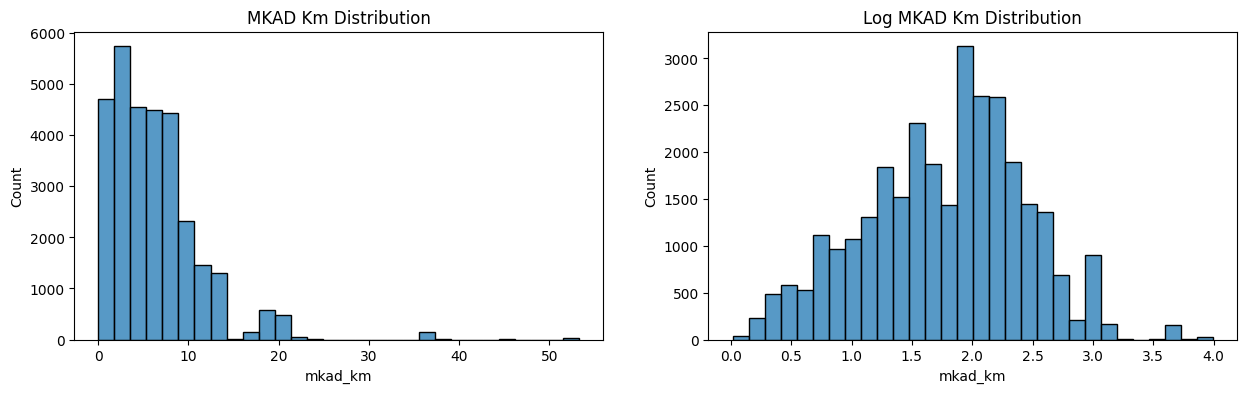

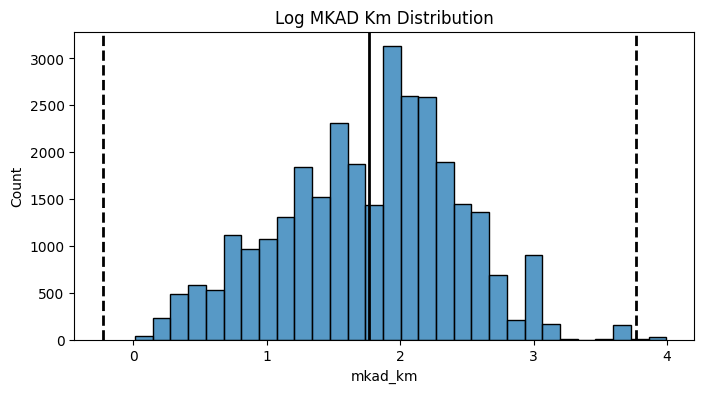

In [20]:
# Правило трёх сигм гласит: если распределение данных является нормальным, то 99,73 % лежат в интервале от
# (мю-3сигма, мю+3сигма), # где мю — математическое ожидание (для выборки это среднее значение), 
# а (сигма) — стандартное отклонение. 
# Наблюдения, которые лежат за пределами этого интервала, будут считаться выбросами.

# А что делать, если данные не распределены нормально? 
# На такой случай есть один трюк. Иногда для распределений, похожих на логнормальное, может помочь логарифмирование. 
# Оно может привести исходное распределение к подобию нормального. Причем, основание логарифма может быть любым. 
# ПРИМЕР 
# Построим две гистограммы признака расстояния до МКАД (mkad_km): первая — в обычном масштабе, а вторая — в логарифмическом. 
# Логарифмировать будем с помощью функции log() из библиотеки numpy (натуральный логарифм — логарифм по основанию числа e). 
# Признак имеет среди своих значений 0. Из математики известно, что логарифма от 0 не существует, 
# поэтому мы прибавляем к нашему признаку 1, чтобы не логарифмировать нули и не получать предупреждения.
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution'); 
# Численный показатель асимметрии можно вычислить с помощью метода:
print(log_mkad_km.skew())

# Как и раньше, функция будет возвращать выбросы и очищенные от них данные:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
# Применим эту функцию к таблице sber_data и признаку mkad_km, а также выведем размерности результатов:
outliers, cleaned = outliers_z_score(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

# Итак, метод z-отклонения нашел нам 33 потенциальных выброса по признаку расстояния до МКАД. Давайте узнаем, 
# в каких районах (sub_area) представлены эти квартиры:

print(outliers['sub_area'].unique())
['Poselenie Rogovskoe' 'Poselenie Kievskij']

# Наши потенциальные выбросы — это квартиры из поселений «Роговское» и «Киевский». Снова обращаемся к силе интернета 
# и «пробиваем» наших подозреваемых. Эти поселения — самые удалённые районы Москвы; первое из них — это и вовсе 
# граница с Калужской областью. 

# И тут возникает закономерный вопрос: а стоит ли считать такие наблюдения за выбросы? 
# Вопрос в действительности не имеет определенного ответа: с одной стороны, метод прямо-таки говорит нам об этом, 
# а с другой — эти наблюдения имеют право на существование, ведь они являются частью Москвы. 
# Возможно, мы не учли того факта, что наш логарифм распределения всё-таки не идеально нормален и в нём присутствует 
# некоторая асимметрия. Возможно, стоит дать некоторое «послабление» на границы интервалов? Давайте отдельно 
# построим гистограмму прологарифмированного распределения, а также отобразим на гистограмме вертикальные линии, 
# соответствующие среднему (центру интервала в методе трёх сигм) и границы интервала мю+3сигма. 
# Вертикальные линии можно построить с помощью метода axvline(). Для среднего линия будет обычной, 
# а для границ интервала — пунктирной (параметр ls ='--'):
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean()+ 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean()- 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution'); 

# Итак, что мы графически построили интервал метода трёх сигм поверх нашего распределения. Он показывает, 
# какие наблюдения мы берем в интервал, а какие считаем выбросами. Легко заметить, среднее значение (жирная вертикальная 
# линия) находится левее моды, это свойство распределений с левосторонней асимметрией. Также видны наблюдения, 
# которые мы не захватили своим интервалом (небольшой пенек правее верхней границы) — это и есть наши квартиры из 
# поселений "Роговское" и "Киевский". Очевидно, что если немного (меньше чем на одну сигму) "сдвинуть" верхнюю границу 
# вправо, мы захватим эти наблюдения.

Задание 6.3

In [22]:
def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

Задание 6.4

In [21]:
def outliers_z_score_mod(data, feature, left=3, right=3.5, log_scale=True):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score_mod(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

#Стоило нам немного увеличить правую границу метода z-отклонений, как мы получили отсутствие выбросов в признаке. 
# Давать ли такие «послабления» или нет — это ваше решение и полностью зависит от специфики задачи, однако вы можете 
# пользоваться этим трюком, чтобы более тщательно подходить к поиску аномалий.

Число выбросов по методу z-отклонения: 0
Результирующее число записей: 30471


Задание 6.5

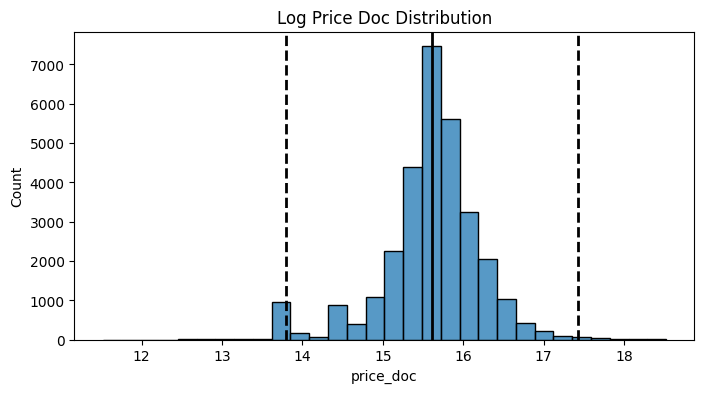

In [23]:
# Постройте гистограмму для признака price_doc в логарифмическом масштабе. А также, добавьте на график линии, 
# отображающие среднее и границы интервала для метода трех сигм. 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_price_doc = np.log(sber_data['price_doc'] + 1)
histplot = sns.histplot(log_price_doc, bins=30, ax=ax)
histplot.axvline(log_price_doc.mean(), color='k', lw=2)
histplot.axvline(log_price_doc.mean()+ 3 * log_price_doc.std(), color='k', ls='--', lw=2)
histplot.axvline(log_price_doc.mean()- 3 * log_price_doc.std(), color='k', ls='--', lw=2)
histplot.set_title('Log Price Doc Distribution'); 

Задание 6.6

Число выбросов по методу z-отклонения: 52
Результирующее число записей: 30419


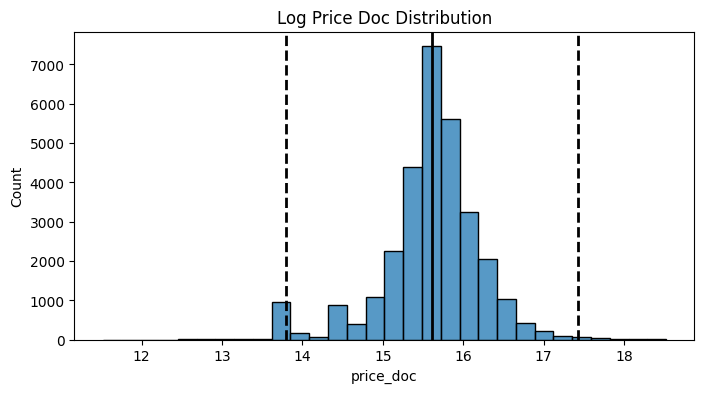

In [29]:
# Найдите потенциальные выбросы по признаку price_doc с помощью метода z-отклонения. Используйте логарифмический 
# масштаб распределения. Сделайте «послабление» на 0.7 сигм в обе стороны распределения. Сколько выбросов вы получили?
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3.7 *sigma
    upper_bound = mu + 3.7 *sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_price_doc = np.log(sber_data['price_doc'] + 1)
histplot = sns.histplot(log_price_doc, bins=30, ax=ax)
histplot.axvline(log_price_doc.mean(), color='k', lw=2)
histplot.axvline(log_price_doc.mean()+ 3 * log_price_doc.std(), color='k', ls='--', lw=2)
histplot.axvline(log_price_doc.mean()- 3 * log_price_doc.std(), color='k', ls='--', lw=2)
histplot.set_title('Log Price Doc Distribution'); 

outliers, cleaned = outliers_z_score(sber_data, 'price_doc', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Задание 6.7

In [32]:
# Добавьте фишку с логарифмированием в свою функцию outliers_iqr_mod(). Добавьте в неё параметр log_scale. 
# Если он выставлен в True, то производится логарифмирование признака. Примените полученную функцию к признаку 
# price_doc.Число межквартильных размахов в обе стороны обозначьте как 3. 
# Чему равно число выбросов, полученных таким методом?
def outliers_iqr_mod(data, feature, left=3, right=3, log_scale=True):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x> upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 92
Результирующее число записей: 30379
